# The Market for AI
Previously, we saw models like Logistic Regression and Random Forests, which
were examples of supervised learning. That is, these models were fed labelled
data (X, y), then learned a relationship among the data in order to make a 
prediction. Yet, the data we collect won't always have a label, and that's
where different unsupervised learning techniques can help. 

For example, take customer segmentation. Say you've developed a tool for Airbnb 
hosts that automates their guest interactions and you have four different 
subscription tiers. You'd like to be able to market each tier to different 
groups, but your not sure which customer fits in which group. K-means clustering 
is a method  that partitions a dataset into k different groups, with each data 
point belonging to the cluster with the nearest mean. With it, we can take our 
data and segment it into any number of groups we want.

So, we run k-means on our data and seperate different groups, but now we would 
like to get a sense for what's happening by graphing it. The problem is the 
data has many feautures (number of properties managed, size of each property,
location), and we can only graph something in three dimensions (x, y, and z 
axes). Principal Component Analysis is meant to reduce the number of features 
under consideration and to help focus the analysis on the so-called 
"principal component" affecting the behavior of the data. With a tool like 
Principal Component Analysis (PCA), we can reduce the dimensionality of our 
data to a viewable form. Let's take a look at our Boston housing data to get a 
feel for these tools.

## Infrastructure
We'll load all the functions that we'll be using later here:

In [1]:
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.datasets import load_boston
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns; sns.set()

def norm_data(X):
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    X_norm = (X - mu) / sd

    return X_norm

def pca_transform(n, data, inv = False):
    pca = PCA(n_components = n, random_state = 0)
    data_norm = norm_data(data)
    Z = pca.fit_transform(data_norm)
    if inv:
        Z = pca.inverse_transform(Z)*data.std(axis=0) + data.mean(axis=0)

    return Z

def plot_PCs(n, data, y, km = False):

    Z = pca_transform(n, data)

    if km:
        kmeans = KMeans(4)
        kmeans.fit(Z)
        cl = kmeans.labels_

    # split data by MEDV > mean
    gt = Z[y==1]
    lt = Z[y==0]

    # 3D K-Means
    if km and n == 3:
        ax = plt.subplot(projection='3d')
        ax.scatter3D(Z[:,0], Z[:,1], Z[:,2], c=cl,  cmap = "Accent")

        ax = plt.gca()
        ax.set_zlabel("3rd PC")
        plt.xlabel("1st PC")
        plt.ylabel("2nd PC")


    # 3D MEDV split
    elif n == 3:
        ax = plt.subplot(projection='3d')
        ax.scatter3D(gt[:,0], gt[:,1], gt[:,2], marker = '+', cmap = "Accent",
                    label = "Greater than mean MEDV")
        ax.scatter3D(lt[:,0], lt[:,1], lt[:,2], s =5, marker = 'o', cmap = "Accent",
                    label = "Less than mean MEDV")

        ax = plt.gca()
        ax.set_zlabel("3rd PC")
        plt.xlabel("1st PC")
        plt.ylabel("2nd PC")

    # 2D K-Means
    if km and n == 2:
        plt.scatter(Z[:,0], Z[:,1], c=cl,  cmap = "Accent")

        plt.xlabel("1st PC")
        plt.ylabel("2nd PC")
    # 2D MEDV split
    elif n == 2:
        plt.scatter(gt[:,0], gt[:,1],  marker = '+', cmap = "Accent",
                    label = "Greater than mean MEDV")
        plt.scatter(lt[:,0], lt[:,1], s=5, marker = 'o', cmap = "Accent",
                    label = "Less than mean MEDV")
        plt.xlabel("1st PC")
        plt.ylabel("2nd PC")

    # 1D K-Means
    if km and n == 1:
        plt.scatter(Z[:,0],[0]*Z.shape[0], s=5, c=cl, cmap = "Accent")

        plt.xlabel("1st PC")
        plt.title("Boston Housing: PCA Reduced")
        ax = plt.gca()
        ax.set(yticks=[])
    # 1D MEDV split
    elif n == 1:
        plt.scatter(gt[:,0],[0]*gt.shape[0], marker = '+', cmap = "Accent",
                    label = "Greater than mean MEDV")
        plt.scatter(lt[:,0],[0]*lt.shape[0], s=5, marker = 'o', cmap = "Accent",
                    label = "Less than mean MEDV")

        plt.xlabel("1st PC")
        plt.title("Boston Housing: PCA Reduced")
        ax = plt.gca()
        ax.set(yticks=[])

    if not km:
        plt.legend()
    if km:
        plt.title("Boston Housing: PCA and K-Means")
    else:
        plt.title("Boston Housing: PCA Reduced")
    plt.show()

def plot_diff_means(d1, d2, labels):
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.4
    index = np.arange(d1.shape[1])
    mean1 = d1.mean(axis=0)
    mean2 = d2.mean(axis=0)
    diff = 100*(mean1 - mean2) / mean2
    
    rect1 = ax.bar(index, diff, bar_width,
                alpha=opacity, color='b',
                label = "% Difference")

    plt.xticks(index, labels, rotation = 45)
    plt.ylabel("Percentage")
    plt.title("Difference of Means for Of Interest and Original Data")
    plt.legend()
    
    plt.show()

## Principal Component Analysis
First, we'll reduce the dimensionality and take a look at the homes greater and
less than the mean home value (MEDV):

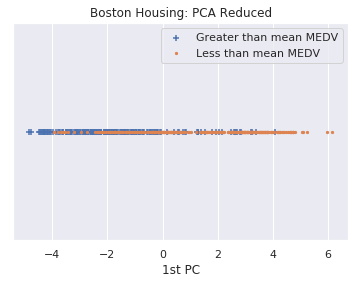

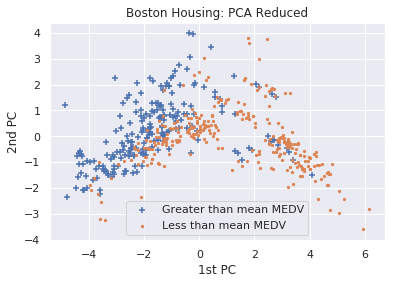

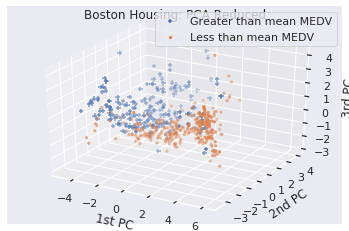

In [2]:
data = load_boston().data
target = load_boston().target
y = np.zeros_like(target)
y[target > target.mean()] = 1

for i in range(1,4):
    plot_PCs(i, data, y)

Originally, our data contained 506 examples with 13 different features and it
wasn't possible to visualize. With the help of PCA, we can reduce our dataset
down to the three, two, or one most important features. And, this makes
visualization possible. 

It's worth taking another look at the graph with one principal component. There
are regions on the edges where homes are mostly greater than or less than MEDV.
By investigating what values of our original 13 features connect to this data, 
we might find a way to pick out these high and low value homes.

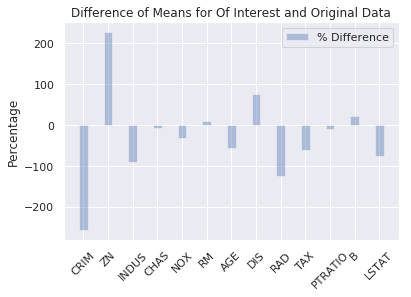

In [3]:
# code to pick out interesting data
Z = pca_transform(1, data)
# of all homes < mean MEDV, what is the least 
min_lt = Z[y==0].min()
ind = []
for i, v in enumerate(Z):
    # grab homes that are to the left of min_lt on PC1 graph
    if v < min_lt:
        ind.append(i)

# go back to 13 features
Z_rec = pca_transform(1, data, inv=True)
# grab points of interest in original 13 feature space
Z_rec[ind]
bar_labels = load_boston().feature_names
# plot diff. between data as a whole and our points of interest
plot_diff_means(Z_rec[ind], data, bar_labels)

CRIM and ZN immediately pop out. the variables are:
- CRIM is the per capita crime rate and 
- ZN is the proportion of residential land zoned for lots over 25,000 sq. ft.

CRIM is much lower and ZN is much bigger. This is probably an exclusive
neighborhood filled with large homes-25,000 sq. ft is pretty big. 


By looking at the graph of the 1st Principal Component, we saw that there were
two regions that stood out from the data: the region < -4 and the region > 4.
We grabbed the data points < -4 and transformed them back to the original 13
feature space. After comparing the means of our data of interest with the
original data, we saw that CRIM and ZN were much different, leading us to the
conclusion that our data of interest probably represents an exclusive
neighborhood filled with large homes. In the following exercise, you will get
the chance to repeat this process for values from the 1st Principal component > 4. 

## Exercise
We saw how to back out the values < -4 from the 1st Principal Component. Now,
repeat the process for values > 4 from the 1st Principal Component. Reference
the graph of the 1st Principal Component above.

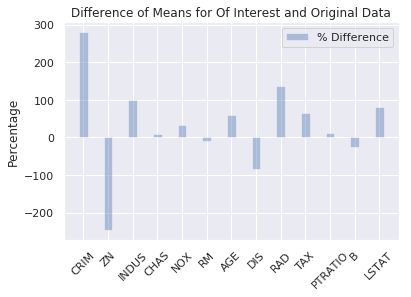

In [4]:
# code to investigate other extreme edge of 1 PC data
Z = pca_transform(1, data)
# of all homes < mean MEDV, what is the least 
max_gt = Z[y==1].max()
ind = []
for i, v in enumerate(Z):
    # grab homes that are to the left of min_lt on PC1 graph
    if v > max_gt:
        ind.append(i)

# go back to 13 features
Z_rec = pca_transform(1, data, inv=True)
# grab points of interest in original 13 feature space
Z_rec[ind]
bar_labels = load_boston().feature_names
# plot diff. between data as a whole and our points of interest
plot_diff_means(Z_rec[ind], data, bar_labels)

## K-Means Clustering 
Now that we're able to visualize our data, let's segment it further. Let's say
you're selling four different versions of a product to families in the Boston
area. You'd like to segment your potential customers into four distinct groups,
so you can better target your advertising to them. Let's perform k-means on
the PCA-reduced Boston Housing data:

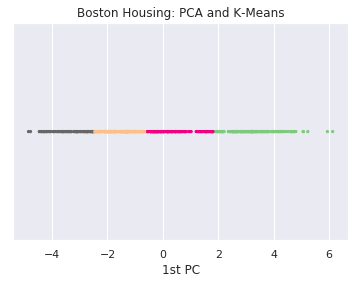

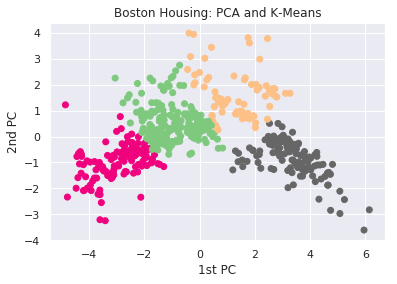

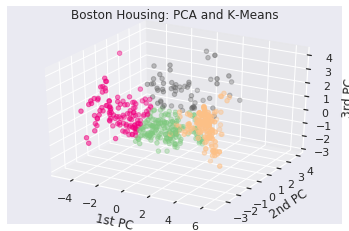

In [5]:
for i in range(1,4):
    plot_PCs(i, data, y, km = True)

We could then follow the same process to back out what our groups looks like in
our original data to come up with profiles on them. 

K-means clustering is a powerful tool that can help you group your data better. 
Without any labels, k-means is able to group the housing data into any number
of clusters. This can be very useful especially for customer segmentation. 

## Additional Exercise 
Clustering or segmenting a dataset into different groups is valuable for a
number of cases; for example, trying to target customers for specific products
within a product offering. For further practice:
- Investigate how the different clusters correspond to the original 13
  features by following the same procedure for PCA from earlier. 
    - isolate what principal component values correspond to each group
    - back out your highlighted data to the original 13 feature space
    - compare the means of highlighted data to those of the original data


## Additional Reading
If you're interested in digging in deeper to the math, here are some helpful
resources:

- [Andrew Ng on K-Means](https://www.youtube.com/watch?v=Ev8YbxPu_bQ)
- [PCA Tutorial](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf)

## Conclusion
We've seen two new tools from unsupervised learning (learning on unlabeled
data): K-Means and PCA. K-means was able to find unique labels for our data
based on the number of groups we wantd. PCA reduced the dimensionality of our
data, making it possible to visualize. These are both effective tools because
most of the data in the wild doesn't come with a label at first. PCA and
K-Means are able add meaning to this data.